# Import the necessary libraries

In [1]:
import sys
sys.path.append("../../../Utils/")

In [2]:
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
import utils
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# Load the data

In [3]:
output_path = './Output/'

In [4]:
X_train = joblib.load('/home/imad/Desktop/Yelp_vectorized_data/Experiments/Baseline/Restaurents_VS_Home_Services/Restaurants_X.pkl')
X_train.shape

(2927730, 961753)

In [5]:
y_train = joblib.load('/home/imad/Desktop/Yelp_vectorized_data/Baseline/Restaurants_y.pkl')
y_train.shape

(2927730,)

In [6]:
X_b = joblib.load('/home/imad/Desktop/Yelp_vectorized_data/Experiments/Baseline/Restaurents_VS_Home_Services/Homes_X.pkl')
X_b.shape

(170623, 961753)

In [7]:
y_b = joblib.load('/home/imad/Desktop/Yelp_vectorized_data/Baseline/Home_Services_y.pkl')
y_b.shape

(170623,)

In [8]:
X_b_train, X_test, y_b_train, y_test = train_test_split(X_b, y_b, test_size=0.3, random_state=0, stratify=y_b)
del X_b_train
del y_b_train

# Remove 3-star ratings and re-label the training dataset

In [9]:
neutral_ratings_ids = list(np.where(y_train == 3)[0])
len(neutral_ratings_ids)

417488

In [10]:
X_train = utils.delete_from_csr(X_train.tocsr(), row_indices=neutral_ratings_ids)

In [11]:
X_train.shape

(2510242, 961753)

In [12]:
y_train = np.delete(y_train.tolist(), neutral_ratings_ids)

In [13]:
for i in range(0, len(y_train)):
    if y_train[i] == 1 or y_train[i] == 2:
        y_train[i] = -1
    else:
        y_train[i] = 1

# Re-label in the test dataset:
## 0,1 -> -1
## 4, 5 -> 1
## 3 -> 0

In [14]:
for i in y_test.index:
    if y_test[i] == 1 or y_test[i] == 2:
        y_test[i] = -1
    elif y_test[i] == 4 or y_test[i] == 5:
        y_test[i] = 1
    else:
        y_test[i] = 0

In [15]:
y_test.value_counts()

 1.0    35243
-1.0    14558
 0.0     1386
Name: stars, dtype: int64

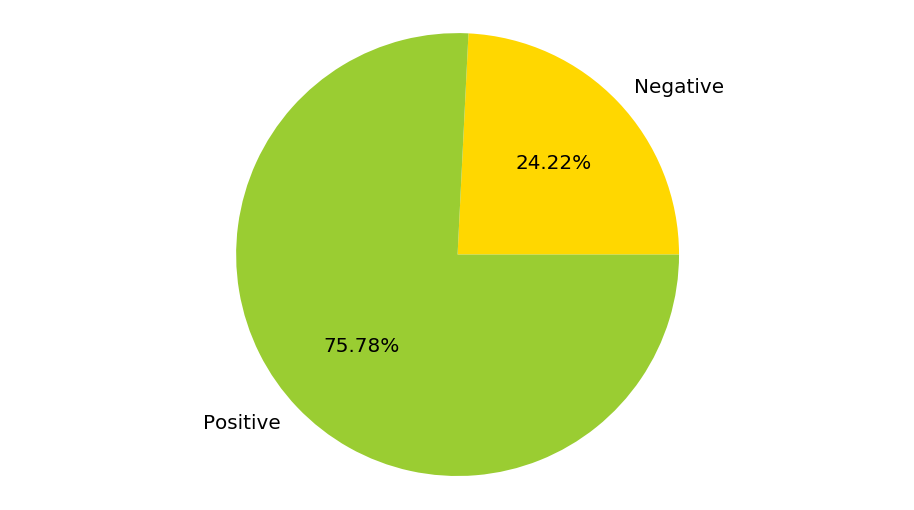

In [16]:
# Rating Distribution
values, counts = np.unique(y_train, return_counts=True)
colors = ['gold', 'yellowgreen']

# Plot
mpl.rcParams['font.size'] = 20.0
f = plt.figure()
f.set_size_inches(16,9)
plt.pie(counts, labels=['Negative', 'Positive'], colors=colors, autopct='%1.2f%%')
plt.axis('equal')
plt.show()
f.savefig(output_path + 'Distribution.pdf')

# Optimizing MNB paramters

In [17]:
MNB = MultinomialNB()
MNB

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
params = {'alpha': np.arange(0.1, 1.1, 0.1)}
grid = GridSearchCV(MNB, params, scoring='f1_weighted')
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [19]:
grid.best_estimator_

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
grid.grid_scores_

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92183, std: 0.00087, params: {'alpha': 0.1},
 mean: 0.92221, std: 0.00086, params: {'alpha': 0.2},
 mean: 0.92248, std: 0.00090, params: {'alpha': 0.30000000000000004},
 mean: 0.92263, std: 0.00094, params: {'alpha': 0.4},
 mean: 0.92280, std: 0.00094, params: {'alpha': 0.5},
 mean: 0.92294, std: 0.00092, params: {'alpha': 0.6},
 mean: 0.92303, std: 0.00094, params: {'alpha': 0.7000000000000001},
 mean: 0.92316, std: 0.00092, params: {'alpha': 0.8},
 mean: 0.92322, std: 0.00089, params: {'alpha': 0.9},
 mean: 0.92332, std: 0.00089, params: {'alpha': 1.0}]

In [21]:
MNB = grid.best_estimator_

# Cross-validation

In [22]:
MNB_scores = cross_val_score(MNB, X_train, y_train, cv=5, scoring='f1_weighted')
MNB_scores

array([0.92504217, 0.92286871, 0.9232839 , 0.92206238, 0.92287006])

# Save the trained model in a pickle file

In [23]:
joblib.dump(MNB, output_path + 'MNB_r_h.pkl')

['./Output/MNB_r_h.pkl']

# Apply the model on the test data

In [24]:
MNB_pred = MNB.predict(X_test)
MNB_pred_prob = MNB.predict_proba(X_test)
print('Predictions: {}'.format(MNB_pred))
print('Predictions Probabilities: {}'.format(MNB_pred_prob.round(2)))

Predictions: [-1. -1. -1. ... -1. -1. -1.]
Predictions Probabilities: [[0.98 0.02]
 [1.   0.  ]
 [1.   0.  ]
 ...
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]]


# Choose a range of probabilities where the model is confused

In [25]:
# Calculate the difference between the two prediction of a data point
diff = [abs(pred[0] - pred[1]) for pred in MNB_pred_prob]
diff_sr = pd.Series(diff)
diff_sr.describe()

count    51187.000000
mean         0.991024
std          0.062557
min          0.010879
25%          0.999995
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

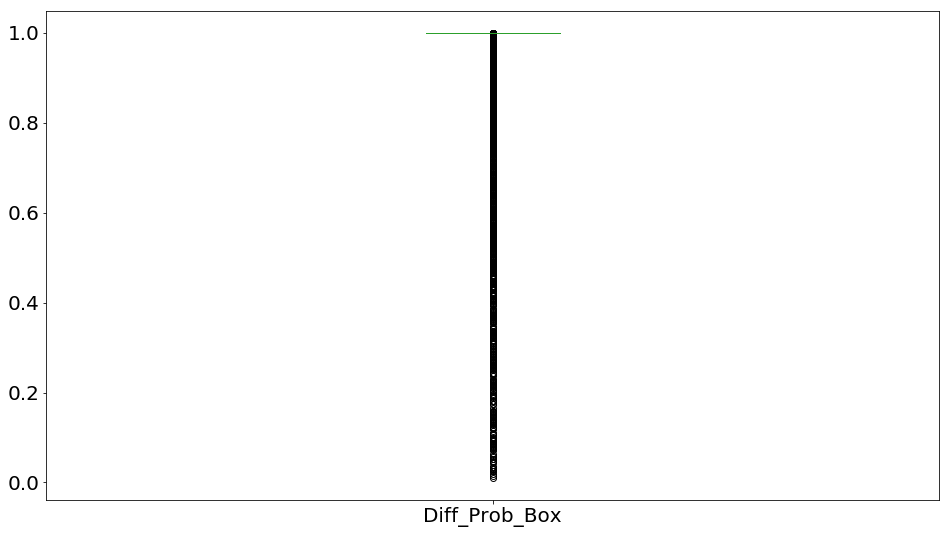

In [26]:
p = diff_sr.plot.box(figsize=(16,9), label='Diff_Prob_Box')
p.figure.savefig(output_path + 'Diff_Prob_Box.pdf')

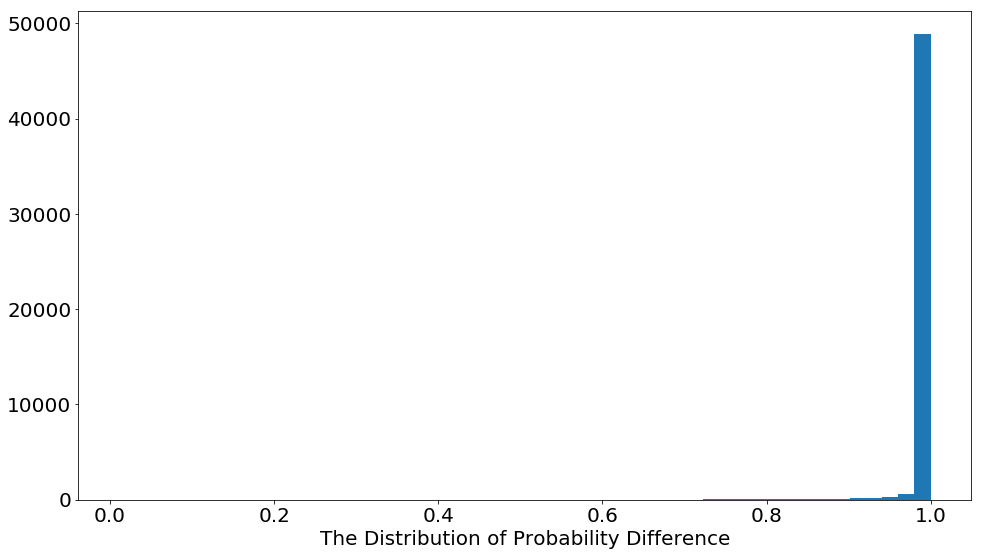

In [27]:
p = diff_sr.hist(bins=50, figsize=(16,9), grid=False)
p.set_xlabel('The Distribution of Probability Difference')
p.figure.savefig(output_path + 'Diff_Prob_Hist.pdf')

In [28]:
# If the difference between the p(0|x) and p(1|x) is smaller than 0.6 (it's enough as a threshold)
ix_ambig = [ix for ix in range(MNB_pred_prob.shape[0]) if abs(MNB_pred_prob[ix][0] - MNB_pred_prob[ix][1]) < 0.6]
print(len(ix_ambig))

381


In [29]:
# Label all the ambiguous data points as 3-star
for i in ix_ambig:
    MNB_pred[i] = 0

In [30]:
pd.Series(MNB_pred).value_counts()

-1.0    50793
 0.0      381
 1.0       13
dtype: int64

In [31]:
joblib.dump(MNB_pred, output_path + 'Predictions.pkl')

['./Output/Predictions.pkl']

# MNB Results

In [32]:
MNB_accuracy = round(accuracy_score(y_test, MNB_pred), 2)
print('Model Accuracy: {}'.format(MNB_accuracy))
with open(output_path + 'Accuracy.txt', 'wb') as f:
    f.write(str(MNB_accuracy))

Model Accuracy: 0.28


In [33]:
MNB_f1 = round(f1_score(y_test, MNB_pred,average='weighted'), 2)
print('Model F1-Score: {}'.format(MNB_f1))
with open(output_path + 'F1.txt', 'wb') as f:
    f.write(str(MNB_f1))

Model F1-Score: 0.13


In [34]:
# Moment of truth, compare the predictions against the labels of the test dataset
MNB_CM = confusion_matrix(y_test, MNB_pred)
print('Confusion Matrix:\n {}'.format(MNB_CM))

Confusion Matrix:
 [[14505    51     2]
 [ 1378     8     0]
 [34910   322    11]]


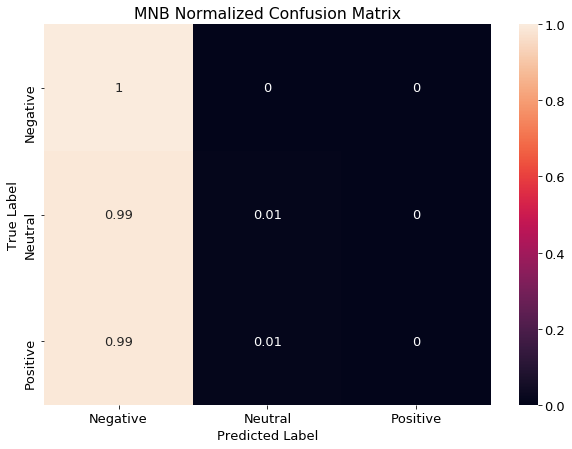

In [35]:
mpl.rcParams['font.size'] = 13.0
utils.cm_plot(MNB_CM, ['Negative', 'Neutral', 'Positive'], 'MNB Normalized Confusion Matrix', output_path + 'MNB_CM.pdf')

In [36]:
print(classification_report(y_test, MNB_pred))

             precision    recall  f1-score   support

       -1.0       0.29      1.00      0.44     14558
        0.0       0.02      0.01      0.01      1386
        1.0       0.85      0.00      0.00     35243

avg / total       0.66      0.28      0.13     51187

